# **E2 - Data Drift in Used Vehicle Price Prediction**

# **P0.1 Exploratory Data Analysis (20%)**

Exploración de datos bivariado y multivariado

In [ ]:
!pip install catboost
!pip install xgboost
!pip install dash
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Carga de datos
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')
print(f"El DataFrame tiene {data.shape[0]} filas y {data.shape[1]} columnas.")

El DataFrame tiene 500000 filas y 6 columnas.


In [ ]:
# Muestra para poder correrlo en el colab
#data = data.sample(n=9000, random_state=42)

In [ ]:
# Descripción estadística inicial de los datos
data.describe()
print(data.dtypes)

Price       int64
Year        int64
Mileage     int64
State      object
Make       object
Model      object
dtype: object


In [ ]:
# Eliminación de valores nulos en las columnas relevantes
data = data.dropna(subset=['Price', 'Year', 'Mileage'])

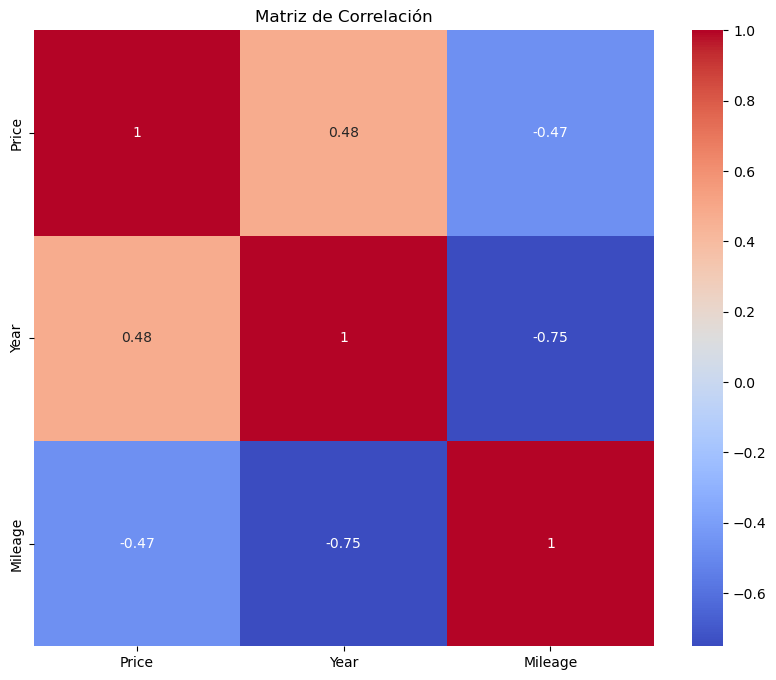

In [ ]:
# Matriz de correlación entre las variables numéricas
corr = data[['Price', 'Year', 'Mileage']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

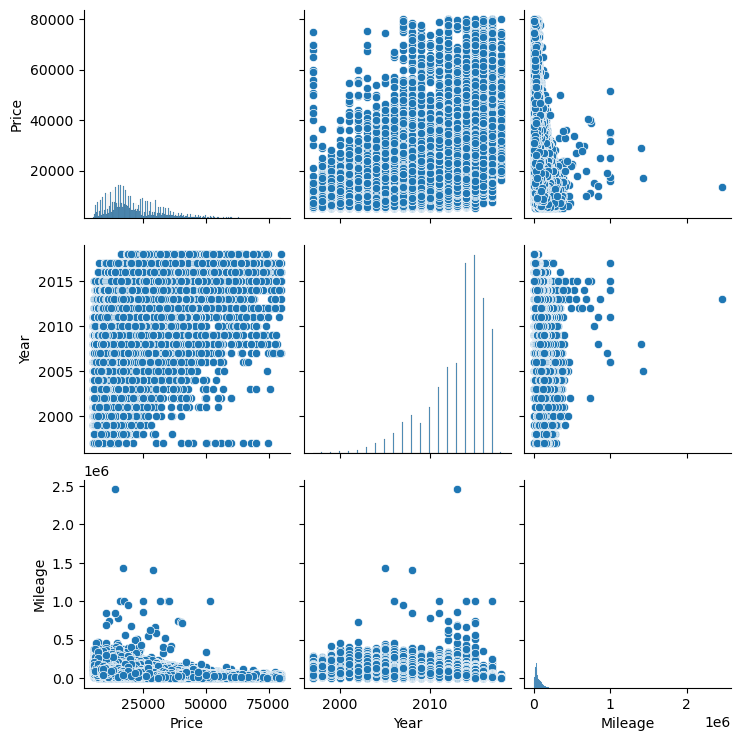

In [ ]:
# Gráficos de pares entre las variables numéricas
sns.pairplot(data[['Price', 'Year', 'Mileage']])
plt.show()

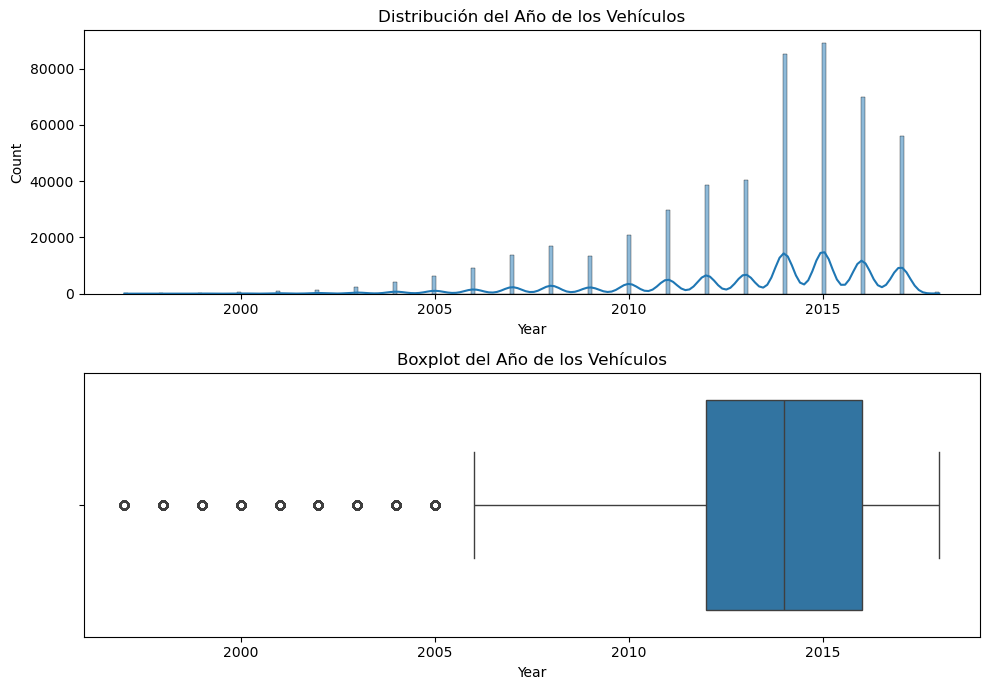

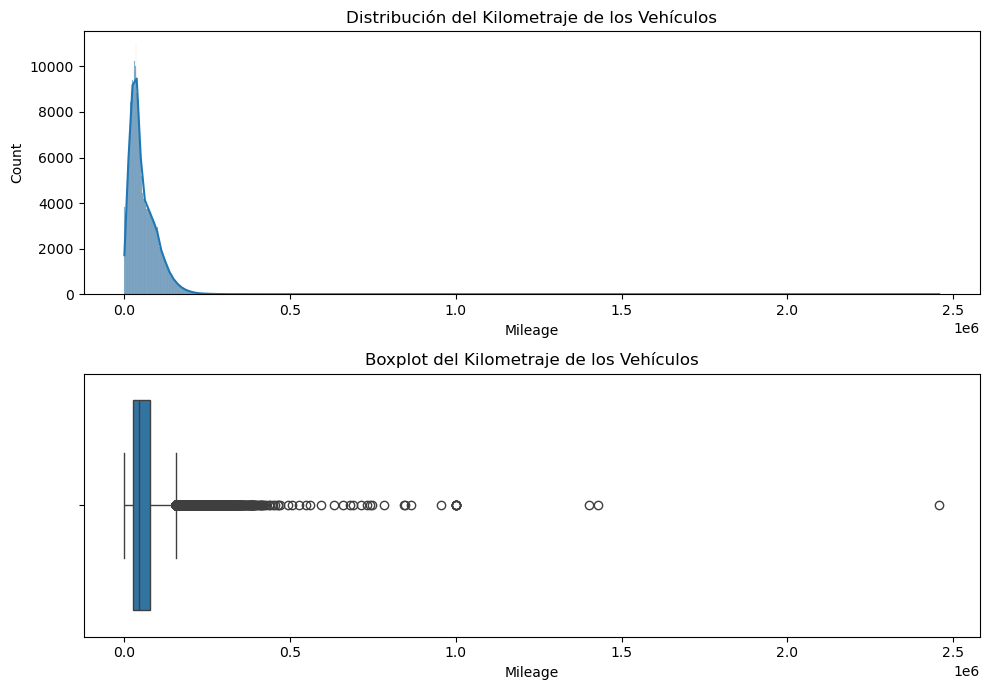

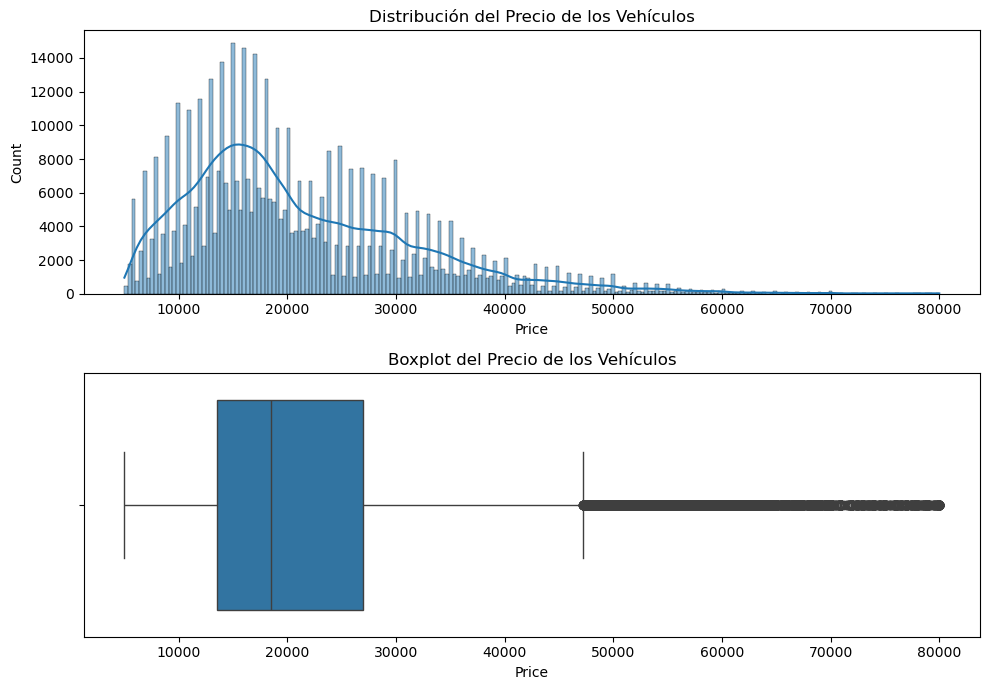

In [ ]:
# Análisis de la distribución de características numéricas
# Visualización para la variable 'Year'
plt.figure(figsize=(10, 7))

# Histograma de 'Year'
plt.subplot(2, 1, 1)
sns.histplot(data=data, x='Year', kde=True)
plt.title('Distribución del Año de los Vehículos')

# Boxplot de 'Year'
plt.subplot(2, 1, 2)
sns.boxplot(data=data, x='Year')
plt.title('Boxplot del Año de los Vehículos')

plt.tight_layout()
plt.show()


# Visualización para la variable 'Mileage'
plt.figure(figsize=(10, 7))

# Histograma de 'Mileage'
plt.subplot(2, 1, 1)
sns.histplot(data=data, x='Mileage', kde=True)
plt.title('Distribución del Kilometraje de los Vehículos')

# Boxplot de 'Mileage'
plt.subplot(2, 1, 2)
sns.boxplot(data=data, x='Mileage')
plt.title('Boxplot del Kilometraje de los Vehículos')

plt.tight_layout()
plt.show()


# Visualización para la variable 'Price'
plt.figure(figsize=(10, 7))

# Histograma de 'Price'
plt.subplot(2, 1, 1)
sns.histplot(data=data, x='Price', kde=True)
plt.title('Distribución del Precio de los Vehículos')

# Boxplot de 'Price'
plt.subplot(2, 1, 2)
sns.boxplot(data=data, x='Price')
plt.title('Boxplot del Precio de los Vehículos')

plt.tight_layout()
plt.show()


# **P0.2 Machine Learning Model (20%)**

**Modelos Seleccionados**

**Ridge Regression:** Debido a su fácil interpretación y a que es computacionalmente eficiente, se consideró una buena opción inicial para problemas de predicción de precios. Además, dado que el conjunto de datos incluye tanto variables numéricas como categóricas, Ridge ayuda a reducir el impacto de las características correlacionadas o tener efectos extremos.


**CatBoost:** El estar diseñado específicamente para manejar variables categóricas sin necesidad de transformarlas mediante técnicas como OneHotEncoding, lo hace particularmente adecuado para conjuntos de datos mixtos con variables tanto numéricas como categóricas. Su capacidad para trabajar de manera eficiente con estas variables sin un preprocesamiento intensivo lo convierte en una excelente opción teniendo en cuenta que la mitad de las variables son categóricas.


**XGBoost:** Aun cuando requiere la transformación previa de las variables categóricas, maneja muy bien tanto las variables numéricas como las categóricas una vez preprocesadas. Además, es robusto frente a los outliers, lo cual es relevante en la predicción debido a valores extremos en el kilometraje o el precio.

## Ridge Regression
Se entrenó con un conjunto de datos que incluyó variables categóricas dumificadas y numéricas.

In [ ]:
# Ejecución y evaluación

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Separación de los datos en variables independientes (X) y dependiente (y)
X = data[['Year', 'Mileage', 'State', 'Make', 'Model']]
y = data['Price']

# Dumificar las variables categóricas ('State', 'Make', 'Model')
X = pd.get_dummies(X, columns=['State', 'Make', 'Model'], drop_first=True)

# División 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

# Filtrar 2010
X_train_filtrado_2010 = X_train[X_train['Year'] <= 2010]
y_train_2010 = y_train[X_train['Year'] <= 2010]

# Configuración de validación cruzada K-Fold (K=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# evaluar el modelo Ridge Regression utilizando K-Fold y calcular métricas
def evaluate_ridge_model(model, X, y, kf):
    mse_list, mae_list, r2_list = [], [], []

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Entrenamiento del modelo Ridge Regression
        model.fit(X_train_fold, y_train_fold)

        # Realizar predicciones
        y_pred_fold = model.predict(X_test_fold)

        # Calcular métricas
        mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
        mae_list.append(mean_absolute_error(y_test_fold, y_pred_fold))
        r2_list.append(r2_score(y_test_fold, y_pred_fold))

    # Calcular los promedios de las métricas
    mse = np.mean(mse_list)
    mae = np.mean(mae_list)
    r2 = np.mean(r2_list)

    # Imprimir resultados
    print(f"Ridge Regression Metricas:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")
    print("")

# Entrenamiento y evaluación del modelo Ridge Regression
ridge_model = Ridge(alpha=1.0)
evaluate_ridge_model(ridge_model, X_train_filtrado_2010, y_train_2010, kf)


Ridge Regression Metricas:
MSE: 11034080.17
MAE: 2104.57
R² Score: 0.71



## CatBoost

Se utilizó el modelo CatBoostRegressor, que puede manejar variables categóricas de manera nativa (sin dumificar). Se intento hacer una selección de hiperparametros mediante GridSearchCV, sin embargo, al correrlo con una muestra de los datos generaba métricas más desfavorables que otros modelos y al intentar ejecutar con la totalidad de los datos era demasiado tardado y se pausaba la ejecución.

In [ ]:
# Entrenamiento y evaluación del modelo CatBoost (con variables categóricas originales)
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_catboost = data[['Year', 'Mileage', 'State', 'Make', 'Model']]
y_catboost = data['Price']

# Filtrar 2010
X_train_catboost_2010 = X_catboost[X_catboost['Year'] <= 2010]
y_train_catboost_2010 = y_catboost[X_catboost['Year'] <= 2010]

# Inicializar el modelo CatBoost
catboost_model = CatBoostRegressor(verbose=0, random_state=42)

# Configurar el KFold con 10 divisiones
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Función para evaluar el modelo CatBoost utilizando K-Fold
def evaluate_catboost_model(model, X, y, kf):
    mse_list, mae_list, r2_list = [], [], []

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Identificación de las columnas categóricas
        cat_features = ['State', 'Make', 'Model']

        # Entrenamiento del modelo CatBoost
        model.fit(X_train_fold, y_train_fold, cat_features=cat_features)

        # Realizar predicciones
        y_pred_fold = model.predict(X_test_fold)

        # Calcular métricas
        mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
        mae_list.append(mean_absolute_error(y_test_fold, y_pred_fold))
        r2_list.append(r2_score(y_test_fold, y_pred_fold))

    # Calcular los promedios de las métricas
    mse = np.mean(mse_list)
    mae = np.mean(mae_list)
    r2 = np.mean(r2_list)

    # Imprimir resultados
    print(f"CatBoostRegressor Métricas:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")
    print("")

# Evaluación del modelo CatBoost
evaluate_catboost_model(catboost_model, X_train_catboost_2010, y_train_catboost_2010, kf)



CatBoostRegressor Métricas:
MSE: 8808627.63
MAE: 1882.57
R² Score: 0.77



##  XGBoost

Se utilizó el modelo XGBRegressor, previa dumificación de las variables categoricas.

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Separación de los datos en variables independientes (X) y dependiente (y)
X_xgboost = data[['Year', 'Mileage', 'State', 'Make', 'Model']]
y_xgboost = data['Price']

# Dumificar las variables categóricas ('State', 'Make', 'Model')
X_xgboost = pd.get_dummies(X_xgboost, columns=['State', 'Make', 'Model'], drop_first=True)

# División de los datos 70-30
X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size=0.3, random_state=20)

# Filtrar  2010
X_train_xgboost_2010 = X_train_xgboost[X_train_xgboost['Year'] <= 2010]
y_train_xgboost_2010 = y_train_xgboost[X_train_xgboost['Year'] <= 2010]

# Configuración de validación cruzada K-Fold (K=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Función para evaluar modelos utilizando K-Fold y calcular métricas
def evaluate_xgboost_model(model, X, y, kf):
    mse_list, mae_list, r2_list = [], [], []

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
        mae_list.append(mean_absolute_error(y_test_fold, y_pred_fold))
        r2_list.append(r2_score(y_test_fold, y_pred_fold))

    mse = np.mean(mse_list)
    mae = np.mean(mae_list)
    r2 = np.mean(r2_list)

    print(f"{model.__class__.__name__} Metricas:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")
    print("")

# Entrenamiento y evaluación del modelo XGBoost
xgb_model = XGBRegressor(random_state=42)
evaluate_xgboost_model(xgb_model, X_train_xgboost_2010, y_train_xgboost_2010, kf)


XGBRegressor Metricas:
MSE: 10192079.41
MAE: 2166.23
R² Score: 0.73



##  Ridge Regression (Tuning)
Se optimizó el modelo de Ridge Regression utilizando GridSearchCV para buscar los mejores hiperparámetros.


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Separación de los datos en variables independientes (X) y dependiente (y)
X = data[['Year', 'Mileage', 'State', 'Make', 'Model']]
y = data['Price']

# Dumificar las variables categóricas ('State', 'Make', 'Model')
X = pd.get_dummies(X, columns=['State', 'Make', 'Model'], drop_first=True)

# División de los datos en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

# Filtrar datos para obtener solo vehículos hasta el año 2010
X_train_filtrado_2010 = X_train[X_train['Year'] <= 2010]
y_train_2010 = y_train[X_train['Year'] <= 2010]

# Configuración de validación cruzada K-Fold (K=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir el modelo base de Ridge Regression
ridge_model = Ridge()

# Definir los hiperparámetros que vamos a optimizar
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],  # Prueba diferentes valores de regularización
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],  # Prueba diferentes solvers
    'fit_intercept': [True, False],  # Ajuste del intercepto
}

# Configurar GridSearchCV para optimizar los hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')

# Entrenar el modelo con los datos hasta 2010
grid_search.fit(X_train_filtrado_2010, y_train_2010)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Entrenar el modelo con los mejores hiperparámetros
ridge_best_model = grid_search.best_estimator_

# Evaluación del modelo Ridge optimizado
def evaluate_model(model, X_train, y_train, kf):
    mse_list, mae_list, r2_list = [], [], []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        # Calcular las métricas
        mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
        mae_list.append(mean_absolute_error(y_test_fold, y_pred_fold))
        r2_list.append(r2_score(y_test_fold, y_pred_fold))

    print(f"Ridge Regression Optimized Evaluation:")
    print(f"Mean Squared Error (MSE): {np.mean(mse_list):.2f}")
    print(f"Mean Absolute Error (MAE): {np.mean(mae_list):.2f}")
    print(f"R² Score: {np.mean(r2_list):.2f}")

# Evaluar el modelo con validación cruzada
evaluate_model(ridge_best_model, X_train_filtrado_2010, y_train_2010, kf)


## Ridge Regression con Normalización y Transformación Logarítmica
Se aplicó una transformación logarítmica a la variable objetivo (Price) usando np.log(y + 1). Las variables numéricas fueron normalizadas con StandardScaler y se ajustaron los hiperparámetros del modelo usando GridSearchCV


In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Filtrar las columnas que se usarán
X = data[['Year', 'Mileage', 'State', 'Make', 'Model']]
y = data['Price']

# Dumificar las variables categóricas ('State', 'Make', 'Model')
X = pd.get_dummies(X, columns=['State', 'Make', 'Model'], drop_first=True)

# Aplicar la transformación logarítmica a la variable objetivo (Price)
y_log = np.log(y + 1)  # Agregamos 1 para evitar log(0)

# División de los datos en conjuntos de entrenamiento y prueba (30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

# Filtrar solo vehículos hasta el año 2010
X_train_2010 = X_train[X_train['Year'] <= 2010]
y_train_2010 = y_train[X_train['Year'] <= 2010]

# Normalización de las características numéricas
scaler = StandardScaler()
X_train_2010_scaled = scaler.fit_transform(X_train_2010[['Year', 'Mileage']])
X_train_2010_scaled = pd.DataFrame(X_train_2010_scaled, index=X_train_2010.index, columns=['Year', 'Mileage'])

# Combinar con las columnas categóricas ya dumificadas
X_train_2010_final = pd.concat([X_train_2010_scaled, X_train_2010.drop(['Year', 'Mileage'], axis=1)], axis=1)

# Configuración de validación cruzada K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir el modelo Ridge
ridge = Ridge()

# Definir los parámetros para ajustar
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}

# Configurar GridSearchCV para ajustar el modelo
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=kf, scoring='r2')

# Entrenar el modelo usando los datos hasta 2010
grid_search.fit(X_train_2010_final, y_train_2010)

# Imprimir los mejores hiperparámetros
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluar el modelo con K-Fold y los mejores parámetros
ridge_best = grid_search.best_estimator_

# Función para evaluar el modelo
def evaluate_ridge_model(model, X, y, kf):
    mse_list, mae_list, r2_list = [], [], []

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
        mae_list.append(mean_absolute_error(y_test_fold, y_pred_fold))
        r2_list.append(r2_score(y_test_fold, y_pred_fold))

    mse = np.mean(mse_list)
    mae = np.mean(mae_list)
    r2 = np.mean(r2_list)

    print(f"Ridge Regression Evaluation Metrics (Log-transformed target):")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

# Evaluar el modelo en la parte 2
evaluate_ridge_model(ridge_best, X_train_2010_final, y_train_2010, kf)


Best Parameters: {'alpha': 0.1}
Ridge Regression Evaluation Metrics (Log-transformed target):
Mean Squared Error (MSE): 0.04
Mean Absolute Error (MAE): 0.15
R² Score: 0.76


## Pipeline con Ridge Regression
Se creó un pipeline con transformación de las variables categóricas (OneHotEncoding) y normalización con StandardScaler de las variables numéricas, se aplicó log a la variable objetivo


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Selección de variables numéricas y categóricas
numeric_features = ['Year', 'Mileage']
categorical_features = ['State', 'Make', 'Model']

# Definición de X e y (con logaritmo en la variable objetivo)
X = data[numeric_features + categorical_features]
y = np.log(data['Price'])

# Preprocesamiento (normalización de numéricas y OneHotEncoding de categóricas)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Pipeline para el preprocesamiento
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar el pipeline para transformar X
X_transformed = pipeline.fit_transform(X)

# Configuración de KFold con 10 particiones
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Inicializar listas para almacenar métricas
mse_list, mae_list, r2_list = [], [], []

# Entrenamiento y validación con KFold
for train_index, test_index in kf.split(X_transformed):
    X_train_fold, X_test_fold = X_transformed[train_index], X_transformed[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Entrenar el modelo Ridge Regression
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_train_fold, y_train_fold)

    # Predicciones
    y_pred_fold = ridge.predict(X_test_fold)

    # Calcular métricas
    mse_list.append(mean_squared_error(y_test_fold, y_pred_fold))
    mae_list.append(mean_absolute_error(y_test_fold, y_pred_fold))
    r2_list.append(r2_score(y_test_fold, y_pred_fold))

# Calcular el promedio de las métricas
mse_mean = np.mean(mse_list)
mae_mean = np.mean(mae_list)
r2_mean = np.mean(r2_list)

# Imprimir métricas promedio
print(f"Pipeline con Ridge Regression Metricas:")
print(f"Mean Squared Error (MSE): {mse_mean:.2f}")
print(f"Mean Absolute Error (MAE): {mae_mean:.2f}")
print(f"R² Score: {r2_mean:.2f}")


Pipeline con Ridge Regression Metricas:
Mean Squared Error (MSE): 0.03
Mean Absolute Error (MAE): 0.12
R² Score: 0.89


**Análisis de las métricas**

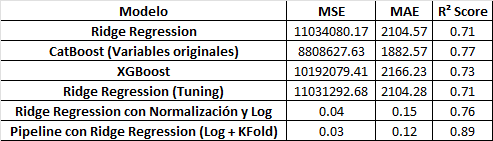

1.	Peor Modelo -  Ridge Regression (Tuning): Aunque este modelo tiene la misma arquitectura que el Ridge Regression original, el proceso de optimización no mejoró el rendimiento, ya que el MSE y el R² score se mantuvieron casi iguales. El hecho de que la optimización de hiperparámetros no haya mejorado el modelo puede deberse a una falta de normalización previa de las características.
2.	Mejor Modelo -  Pipeline con Ridge Regression:
Este modelo ha mostrado el mejor desempeño con un R² Score de 0.89 y los valores más bajos de MSE y MAE. La transformación de las variables fue clave para mejorar la distribución de los datos.
3.	Segundo Mejor Modelo - CatBoostRegressor: Este modelo fue eficaz en la gestión de variables categóricas sin necesidad de realizar un preprocesamiento intensivo, lo que es una ventaja en este conjunto de datos mixtos, sin embargo, no permite mayor exploración.


# **P0.3 Drift Analysis (60%)**

## Pipeline con Ridge Regression

### Análisis de la desviación de los objetivos (20%)

KS test for Price Drift - Statistic: 0.4837, p-value: 0.0000


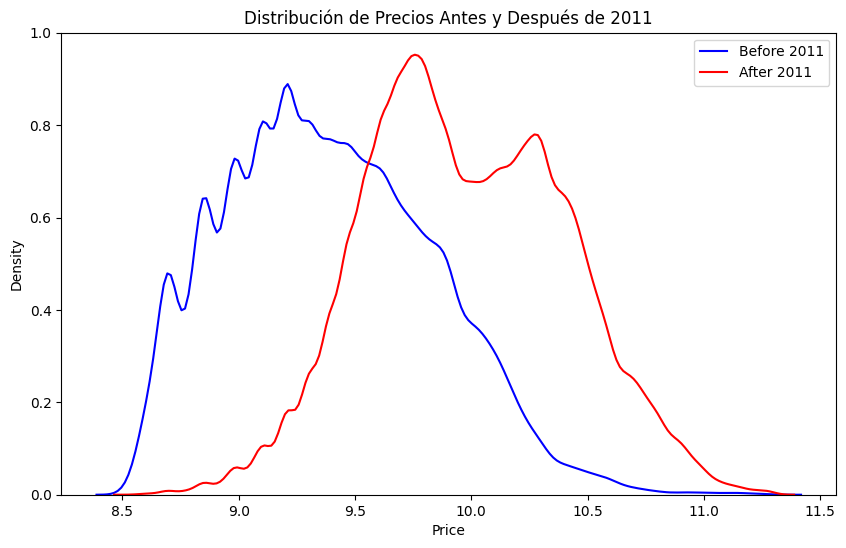

In [ ]:
from scipy.stats import ks_2samp
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar los datos antes y después de 2011
data_post_2011 = data[data['Year'] > 2011]
data_pre_2011 = data[data['Year'] <= 2011]

# Log transformation en el precio para ambos periodos
y_pre_2011 = np.log(data_pre_2011['Price'])
y_post_2011 = np.log(data_post_2011['Price'])

# Prueba KS (Kolmogorov-Smirnov) para detectar desviación en el precio
ks_stat, p_value = ks_2samp(y_pre_2011, y_post_2011)
print(f"KS test for Price Drift - Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

# Visualización de la distribución de precios antes y después de 2011
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pre_2011, label='Before 2011', color='blue')
sns.kdeplot(y_post_2011, label='After 2011', color='red')
plt.title('Distribución de Precios Antes y Después de 2011')
plt.legend()
plt.show()


El análisis de la distribución de precios antes y después de 2011 muestra una clara desviación en los precios del automóvil. El gráfico de densidad (KDE) indica que los precios de los autos después de 2011 (línea roja) tienen una distribución distinta a los precios antes de 2011 (línea azul). El estadístico de 0.4837 y el valor p de 0.0000, confirman que existe una desviación significativa en la distribución de precios entre los dos períodos.

Esto indica que hay desviación en el precio del automóvil, lo que sugiere cambios en los patrones de precios de autos después de 2011, ya sea por factores económcos, del mercado o del tipo de vehículos en venta.

### Análisis de la desviación de datos (20%)

KS test for Year - Statistic: 1.0000, p-value: 0.0000
KS test for Mileage - Statistic: 0.6893, p-value: 0.0000


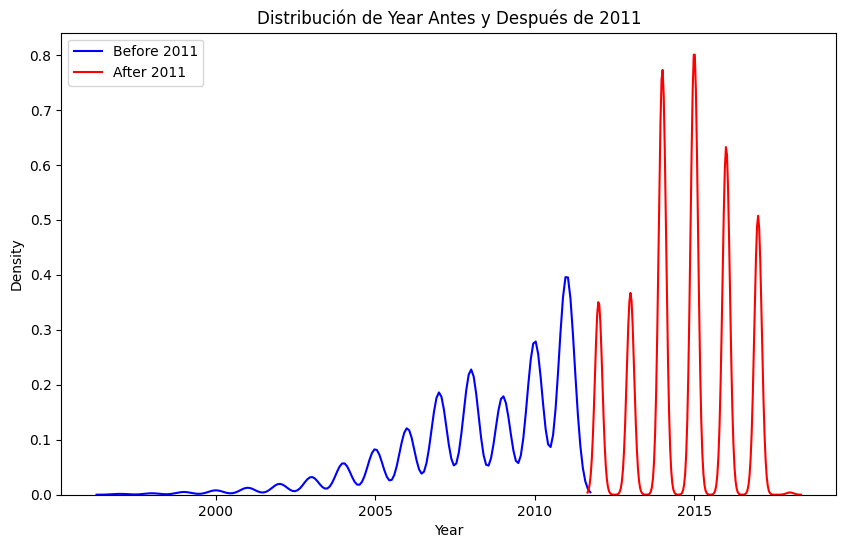

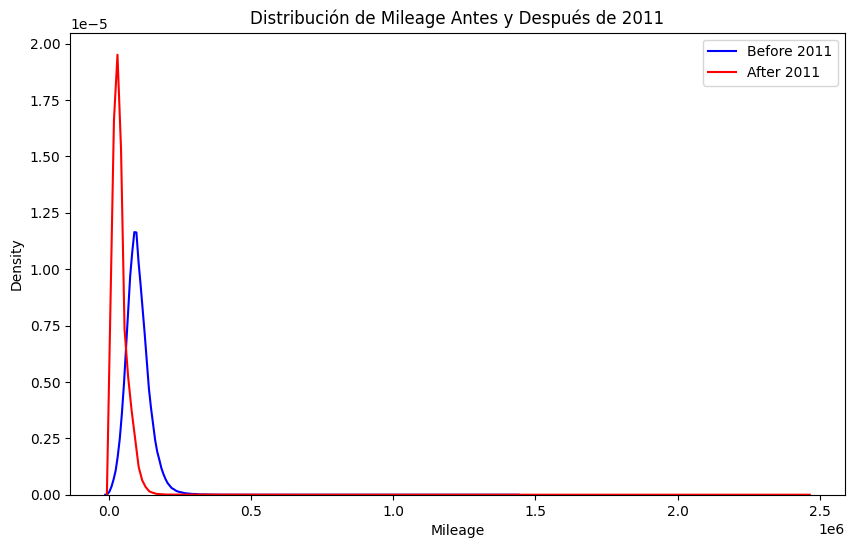

In [ ]:
# Prueba KS (Kolmogorov-Smirnov) para detectar desviación en las características numéricas
for feature in numeric_features:
    ks_stat, p_value = ks_2samp(data_pre_2011[feature], data_post_2011[feature])
    print(f"KS test for {feature} - Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

# Visualización de las distribuciones de las características numéricas antes y después de 2011
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data_pre_2011[feature], label='Before 2011', color='blue')
    sns.kdeplot(data_post_2011[feature], label='After 2011', color='red')
    plt.title(f'Distribución de {feature} Antes y Después de 2011')
    plt.legend()
    plt.show()


**Distribución del Año:** El gráfico de densidad del año muestra que la mayor parte de los autos en el conjunto de datos post-2011 son más nuevos en comparación con los autos antes de 2011.

**Distribución del Kilometraje (Mileage):** El gráfico de densidad muestra que, después de 2011, los autos tienden a tener menos kilometraje en comparación con los autos anteriores a 2011.

### Análisis de la desviación del modelo (20%)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocesamiento de los datos post-2011 con el pipeline
X_post_2011 = data_post_2011[numeric_features + categorical_features]
y_post_2011 = np.log(data_post_2011['Price'])
X_post_2011_transformed = pipeline.transform(X_post_2011)

# Predicciones para el conjunto de datos post-2011
y_pred_post_2011 = ridge.predict(X_post_2011_transformed)

# Calcular métricas de rendimiento para los datos post-2011
mse_post_2011 = mean_squared_error(y_post_2011, y_pred_post_2011)
mae_post_2011 = mean_absolute_error(y_post_2011, y_pred_post_2011)
r2_post_2011 = r2_score(y_post_2011, y_pred_post_2011)

# Imprimir métricas
print(f"Rendimiento del modelo Ridge en los datos post-2011:")
print(f"Mean Squared Error (MSE): {mse_post_2011:.2f}")
print(f"Mean Absolute Error (MAE): {mae_post_2011:.2f}")
print(f"R² Score: {r2_post_2011:.2f}")

# Comparar con las métricas obtenidas en el conjunto de entrenamiento (pre-2011)
mse_pre_2011 = np.mean(mse_list)  # Métrica promedio del modelo en pre-2011
mae_pre_2011 = np.mean(mae_list)  # Métrica promedio del modelo en pre-2011
r2_pre_2011 = np.mean(r2_list)    # Métrica promedio del modelo en pre-2011

print(f"\nComparación de métricas pre-2011 vs post-2011:")
print(f"MSE pre-2011: {mse_pre_2011:.2f}, post-2011: {mse_post_2011:.2f}")
print(f"MAE pre-2011: {mae_pre_2011:.2f}, post-2011: {mae_post_2011:.2f}")
print(f"R² pre-2011: {r2_pre_2011:.2f}, post-2011: {r2_post_2011:.2f}")


Rendimiento del modelo Ridge en los datos post-2011:
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.10
R² Score: 0.89

Comparación de métricas pre-2011 vs post-2011:
MSE pre-2011: 0.03, post-2011: 0.02
MAE pre-2011: 0.12, post-2011: 0.10
R² pre-2011: 0.89, post-2011: 0.89


El R² Score se mantiene en 0.89,el MSE y el MAE son ligeramente mejores después de 2011. Esto indica que no hay desviación significativa en el rendimiento del modelo. El modelo adaptó bien a los datos posteriores a 2011, manteniendo un rendimiento constante en términos de precisión. El hecho de que el modelo mantenga su rendimiento sugiere que las características que predicen el precio de los autos (como el año y el kilometraje) siguen siendo relevantes después de 2011, que seria un buen indicador de que el drift en las características no ha sido lo suficientemente fuerte como para degradar el rendimiento del modelo de manera significativa.

# **BONUS: Drift Dashboard**

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

In [ ]:
# Inicializamos la app Dash
app = dash.Dash(__name__)

In [ ]:

# Datos de drift en las métricas
drift_data = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R²'],
    'Pre-2011': [105980086.30, 6960.77, 0.08],
    'Post-2011': [128410835.05, 8191.59, -0.12]
})

In [ ]:
# Layout de la aplicación
app.layout = html.Div([
    html.H1("Data Drift Dashboard", style={'text-align': 'center'}),

    # Gráfico de barras para las métricas de drift
    dcc.Graph(id='drift-metrics-graph'),

    # Dropdown para seleccionar la característica para visualizar
    html.Div([
        dcc.Dropdown(
            id='feature-dropdown',
            options=[
                {'label': 'Price', 'value': 'Price'},
                {'label': 'Year', 'value': 'Year'},
                {'label': 'Mileage', 'value': 'Mileage'}
            ],
            value='Price',  # Valor inicial
            style={'width': '50%'}
        ),
    ]),

    # Gráfico para mostrar las distribuciones de las características seleccionadas
    dcc.Graph(id='feature-distribution-graph')
])

In [ ]:
# Callback para actualizar el gráfico de métricas de drift
@app.callback(
    Output('drift-metrics-graph', 'figure'),
    Input('feature-dropdown', 'value')
)
def update_drift_metrics(selected_feature):
    fig = px.bar(drift_data, x='Metric', y=['Pre-2011', 'Post-2011'],
                 barmode='group', title="Drift in Model Performance Metrics (Pre vs. Post-2011)")
    return fig

# Callback para actualizar la distribución de la característica seleccionada
@app.callback(
    Output('feature-distribution-graph', 'figure'),
    Input('feature-dropdown', 'value')
)
def update_feature_distribution(selected_feature):
    # Graficar la distribución de la característica seleccionada antes y después de 2011
    fig = px.histogram(data, x=selected_feature, color='Year', nbins=50,
                       title=f"Distribution of {selected_feature} Before and After 2011")
    return fig

In [ ]:
# Ejecutar la aplicación
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>